## Import Libraries

In [2]:
!pip3 install tensorflow keras matplotlib scikit-learn

from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.cm as cm
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

from keras.applications import VGG16
from keras.models import Sequential ,load_model
from keras.layers import Dense, Dropout, Flatten


  Using cached tensorflow-2.12.0-cp39-cp39-macosx_10_15_x86_64.whl (230.1 MB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached matplotlib-3.7.1-cp39-cp39-macosx_10_12_x86_64.whl (7.4 MB)
  Using cached scikit_learn-1.2.2-cp39-cp39-macosx_10_9_x86_64.whl (9.1 MB)
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.9-py2.py3-none-any.whl (26 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached h5py-3.8.0-cp39-cp39-macosx_10_9_x86_64.whl (3.2 MB)
  Using cached jax-0.4.10-py3-none-any.whl
  Using cached libclang-16.0.0-py2.py3-none-macosx_10_9_x86_64.whl (26.7 MB)
  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached protobuf-4.23.1-cp37-abi3-macosx_10_9_universal2.whl (400 kB)
  Using cached termcolor-2.3.0

ModuleNotFoundError: No module named 'google.colab'

## Google Drive connection

In [3]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Utilities

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K
from itertools import cycle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score

dataset_path = "/content/drive/MyDrive/BrainTumorDataset"

# Percorso della cartella "unified" che contiene le sottocartelle delle classi
base_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Unified"

# Definisci i percorsi per il set di test, di validazione e di addestramento
test_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Test"
val_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Validation"
train_path = "/content/drive/MyDrive/BrainTumorDataset/Preprocessed/Train"

#dict of labels
labels_dict= {0:'glioma_tumor', 1:'meningioma_tumor', 2:'no_tumor', 3:'pituitary_tumor'}

def set_seed ():
	''' 
	set_seed is used to obtain reproducible results using keras during the development phase
	'''
	seed = 10
	# The below is necessary for reproducible results of certain Python hash-based operations.
	os.environ["PYTHONHASHSEED"]="0"
	# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
	np.random.seed(seed)
	# The below is necessary for starting core Python generated random numbers in a well-defined state.
	rn.seed(seed)
	# The below tf.random.set_seed will make x number generation in TensorFlow have a well-defined initial state.
	tf.random.set_seed(seed)     

# Definisci le dimensioni delle immagini
image_size = 250
batch_size = 32
# number of image per row in layer activation visualization
images_per_row = 16


# Crea un oggetto ImageDataGenerator per il preprocessing delle immagini
data_generator = ImageDataGenerator(rescale=1.0/255.0)

# Carica le immagini dal set di addestramento
train_generator = data_generator.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Carica le immagini dal set di test
test_generator = data_generator.flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Carica le immagini dal set di validazione
val_generator = data_generator.flow_from_directory(
    val_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)
     

def show_training_and_validation_performance(history):
	'''
	show_training_and_validation_performance is used to plot the performances during the training phase
	:param history: object in which are recorded all the events
	'''
	acc = history.history['accuracy']
	val_acc = history.history['val_accuracy']
	loss = history.history['loss']
	val_loss = history.history['val_loss']

	epochs = range(len(acc))

	plt.plot(epochs, acc, 'bo', label='Training accuracy')
	plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
	plt.title('Training and validation accuracy')
	plt.legend()

	plt.figure()

	plt.plot(epochs, loss, 'bo', label='Training loss')
	plt.plot(epochs, val_loss, 'b', label='Validation loss')
	plt.title('Training and validation loss')
	plt.legend()

	plt.show()

def compile_model (model, optimizer='adam', learning_rate = 0.001):
	'''
	compile_model is used to compile the current model
	:param model: model to compile
	:param optimizer: optimizer to be used
	:param learning_rate: learning rate parameter for the optimizer
	'''
	if optimizer == 'adam':
		model.compile(loss="categorical_crossentropy",
		optimizer=optimizers.Adam(learning_rate=learning_rate),
		metrics=["accuracy"])
	elif optimizer == 'rmsprop':
		model.compile(loss="categorical_crossentropy",
					optimizer = optimizers.RMSprop(learning_rate=learning_rate),
					metrics=['accuracy'])
	model.summary()

def run_model (model, model_name, epochs = 100, patience=5, monitor='val_loss'):
	'''
	run_model is used to run the current mode
	:param model: model to run
	:param model_name: name given to save the model
	:param epochs: how many epochs to do
	:param patience: patience value for Early Stopping
	:param monitor: what to monitor for Early Stopping and Model Checkpoint
	'''
	# local save path for the models
	save_path = dataset_path + '/' + model_name + '.h5'
	callbacks_list = [
					keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
					keras.callbacks.ModelCheckpoint(
						filepath = save_path,
						monitor=monitor,
						verbose=1,
						save_best_only=True)
					]
	history = model.fit(train_generator,
						epochs=epochs,
						validation_data=val_generator,
						callbacks=callbacks_list)
	# save on Drive only the best model
	show_training_and_validation_performance(history)

def plot_roc_curve(y_true, y_pred, n_classes, class_labels):

    # Converti le etichette di classe in formato binario
    lb = LabelBinarizer()
    y_true_binary = lb.fit_transform(y_true)

    # Calcola i tassi di FPR e TPR per ogni classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_true_binary[:, i], y_pred[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    plt.figure()
    colors = ['blue', 'red', 'green', 'orange']  # Colori per le diverse classi

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, label='ROC curve {0} ({1:0.2f}%)'.format(class_labels[i], roc_auc[i]*100))

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model (model, test_dataset):
	'''
	evaluate_model is used to plot some statistics about the performance on the test set
	:param model: model to consider
	'''

	# get predictions
	y_score = model.predict(test_generator)
	# convert predictions to classes
	y_pred = np.argmax(y_score, axis=-1)
	# get true classes
	y_true = test_generator.classes
	# extract class labels
	class_labels = list(test_generator.class_indices.keys())
	
	print("Classification report: ")
	print(metrics.classification_report(y_true, y_pred, target_names=class_labels,digits = 4))
	# create and show confusion matrix and roc
	metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred,display_labels=class_labels, xticks_rotation='vertical')
	plot_roc_curve(y_true, y_score, 4, class_labels)

def display_feature_map(layer_names,activations):
	# Now let's display our feature maps
	for layer_name, layer_activation in zip(layer_names, activations):
			# This is the number of features in the feature map
			n_features = layer_activation.shape[-1]

			# The feature map has shape (1, size, size, n_features)
			size = layer_activation.shape[1]

			# We will tile the activation channels in this matrix
			n_cols = n_features // images_per_row
			display_grid = np.zeros((size * n_cols, images_per_row * size))

			# We'll tile each filter into this big horizontal grid
			for col in range(n_cols):
					for row in range(images_per_row):
							channel_image = layer_activation[0,:, :, col * images_per_row + row]
							# Post-process the feature to make it visually palatable
							channel_image -= channel_image.mean()
							channel_image /= channel_image.std()
							channel_image *= 64
							channel_image += 128
							channel_image = np.clip(channel_image, 0, 255).astype('uint8')
							display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

			# Display the grid
			scale = 1. / size
			plt.figure(figsize=(scale * display_grid.shape[1],
													scale * display_grid.shape[0]))
			plt.title(layer_name)
			plt.grid(False)
			plt.imshow(display_grid, aspect='auto', cmap='gray')
			
	plt.show()

def get_img(img_path, target_size=(224,224)):
    img = image.load_img(img_path, target_size=target_size)
    array = image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def get_img_for_pred(img_path, target_size=(224,224)):
	img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
	img_tensor = tf.keras.preprocessing.image.img_to_array(img)  # (height, width, channels)
	img_tensor = np.expand_dims(img_tensor, axis=0) 
	img_tensor /= 255.
	return img_tensor

def decode_predictions(model,pred):
	class_indices = np.argsort(pred)[0, ::-1][:4]  # Ottieni gli indici delle probabilità ordinate in modo decrescente per le prime 4 classi
	class_probabilities = pred[0, class_indices]  # Probabilità corrispondenti alle classi selezionate
	class_labels = [labels_dict[i] for i in class_indices]  # Etichette corrispondenti alle classi selezionate

	for label, probability in zip(class_labels, class_probabilities):
		print(f"{label}: {probability*100:.2f}%")
	
def get_last_conv_layer_index (model):
  '''
  get_last_conv_layer_index is used to retrieve the index of the last convolutional layer of the model
  :param model: model considered
  :return: the index of the last convolutional layer
  '''
  index = 0
  i = 0
  for i, layer in enumerate(model.layers):
    if len(layer.output_shape) == 4:
      index = i # each time we found a conv layer we update the index
  if index == 0: # no conv layers
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  return index
  

def make_heatmap (img_array, model, last_conv_layer_index, class_index):
  '''
  make_heatmap is used to create the heatmap that shows the gradient-weighted class activation mapping
  :param img_array: a numpy array that represents the image
  :param model: model considered
  :param last_conv_layer_index: index of the last convolutional layer of the model
  :param class_index: class of the image 
  :return: the heatmap
  '''
  # We create a model that maps the input image to the activations of the last convolutional layer 
  # And a model that maps the input image to the predictions
  intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.layers[last_conv_layer_index + 1].input)
  classifier_model = keras.Model([model.layers[last_conv_layer_index + 1].input], model.output)

  # We compute the gradient of the predictions with respect to the activations of the last convolutional layer
  with tf.GradientTape() as tape:
    last_conv_layer_output = intermediate_layer_model(img_array)
    prediction = classifier_model(last_conv_layer_output)
    tape.watch([last_conv_layer_output, prediction])
    if class_index == 0: # hem class
      prediction = 1 - prediction

  # gradient of the output neuron with respect to the output feature map of the last conv layer
  grads = tape.gradient(prediction, last_conv_layer_output)

  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() # evaluate the mean over the gradient tensor, for each channel separately
  weighted_last_conv_layer_output = last_conv_layer_output.numpy()[0]
  for i in range(pooled_grads.shape[-1]):
    weighted_last_conv_layer_output[:, :, i] *= pooled_grads[i] # the i-th feature map is weighted with the i-th gradient

  heatmap = np.mean(weighted_last_conv_layer_output, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

def compute_gradcam(img_path, heatmap, alpha=0.4):
  '''
  compute_gradcam is used to superimpose the heatmap on top of the image
  :param img_path: where is located the image
  :param heatmap: heatmap precomputed 
  :return: the superimposed image
  '''
  img = keras.preprocessing.image.load_img(img_path)
  img = keras.preprocessing.image.img_to_array(img)

  # rescale heatmap to a range 0-255
  heatmap = np.uint8(255 * heatmap)

  # Use jet colormap to colorize heatmap
  jet = cm.get_cmap("jet")

  # Use RGB values of the colormap
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Create an image with RGB colorized heatmap
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Superimpose the heatmap on original image
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)
  return superimposed_img

def display_gradcam(img_path, heatmap, alpha=0.4):
  '''
  display_gradcam is used to print the heatmap of class activations
  :param img_path: where is located the image
  :param heatmap: heatmap precomputed 
  '''
  superimposed_img = compute_gradcam(img_path, heatmap, alpha)
  plt.figure(figsize= (10,10))
  plt.imshow(superimposed_img)

def clear(model):
	del model
	K.clear_session() 

set_seed ()

Found 4488 images belonging to 4 classes.
Found 646 images belonging to 4 classes.
Found 646 images belonging to 4 classes.


# Sample Image

(1, 250, 250, 3)


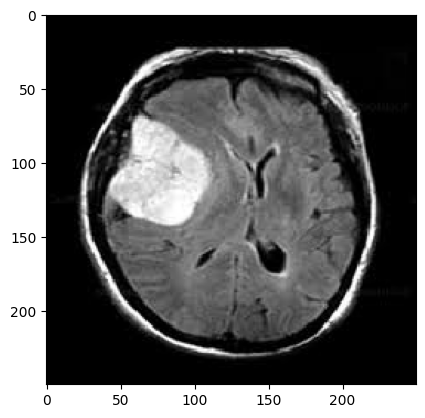

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 10, 10, 128)     

In [16]:
model_path = os.path.join(dataset_path,"Models/cnn_from_scratch_exp8/cnn_from_scratch_exp8.h5")
model = load_model(model_path)
# get a random image from test set
img_path = os.path.join(test_path,"meningioma_tumor/meningioma_tumor_307.jpg")
# load the image
img_tensor = get_img(img_path, target_size=(image_size, image_size))
print(img_tensor.shape)

# display it
plt.imshow(img_tensor[0].astype('uint8'))
plt.show()
model.summary()

# Visualize Conv and Pooling activation

In [53]:
#get all conv and pooling layers
layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        print(layer.name)
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of N Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
print(len(activations))
for out in activations:
  print(out.shape)

conv2d_4
max_pooling2d_4
conv2d_5
max_pooling2d_5
conv2d_6
max_pooling2d_6
conv2d_7
max_pooling2d_7
1/1 [==============================] - 0s 74ms/step
8
(1, 250, 250, 32)
(1, 125, 125, 32)
(1, 125, 125, 64)
(1, 41, 41, 64)
(1, 41, 41, 128)
(1, 10, 10, 128)
(1, 10, 10, 256)
(1, 2, 2, 256)


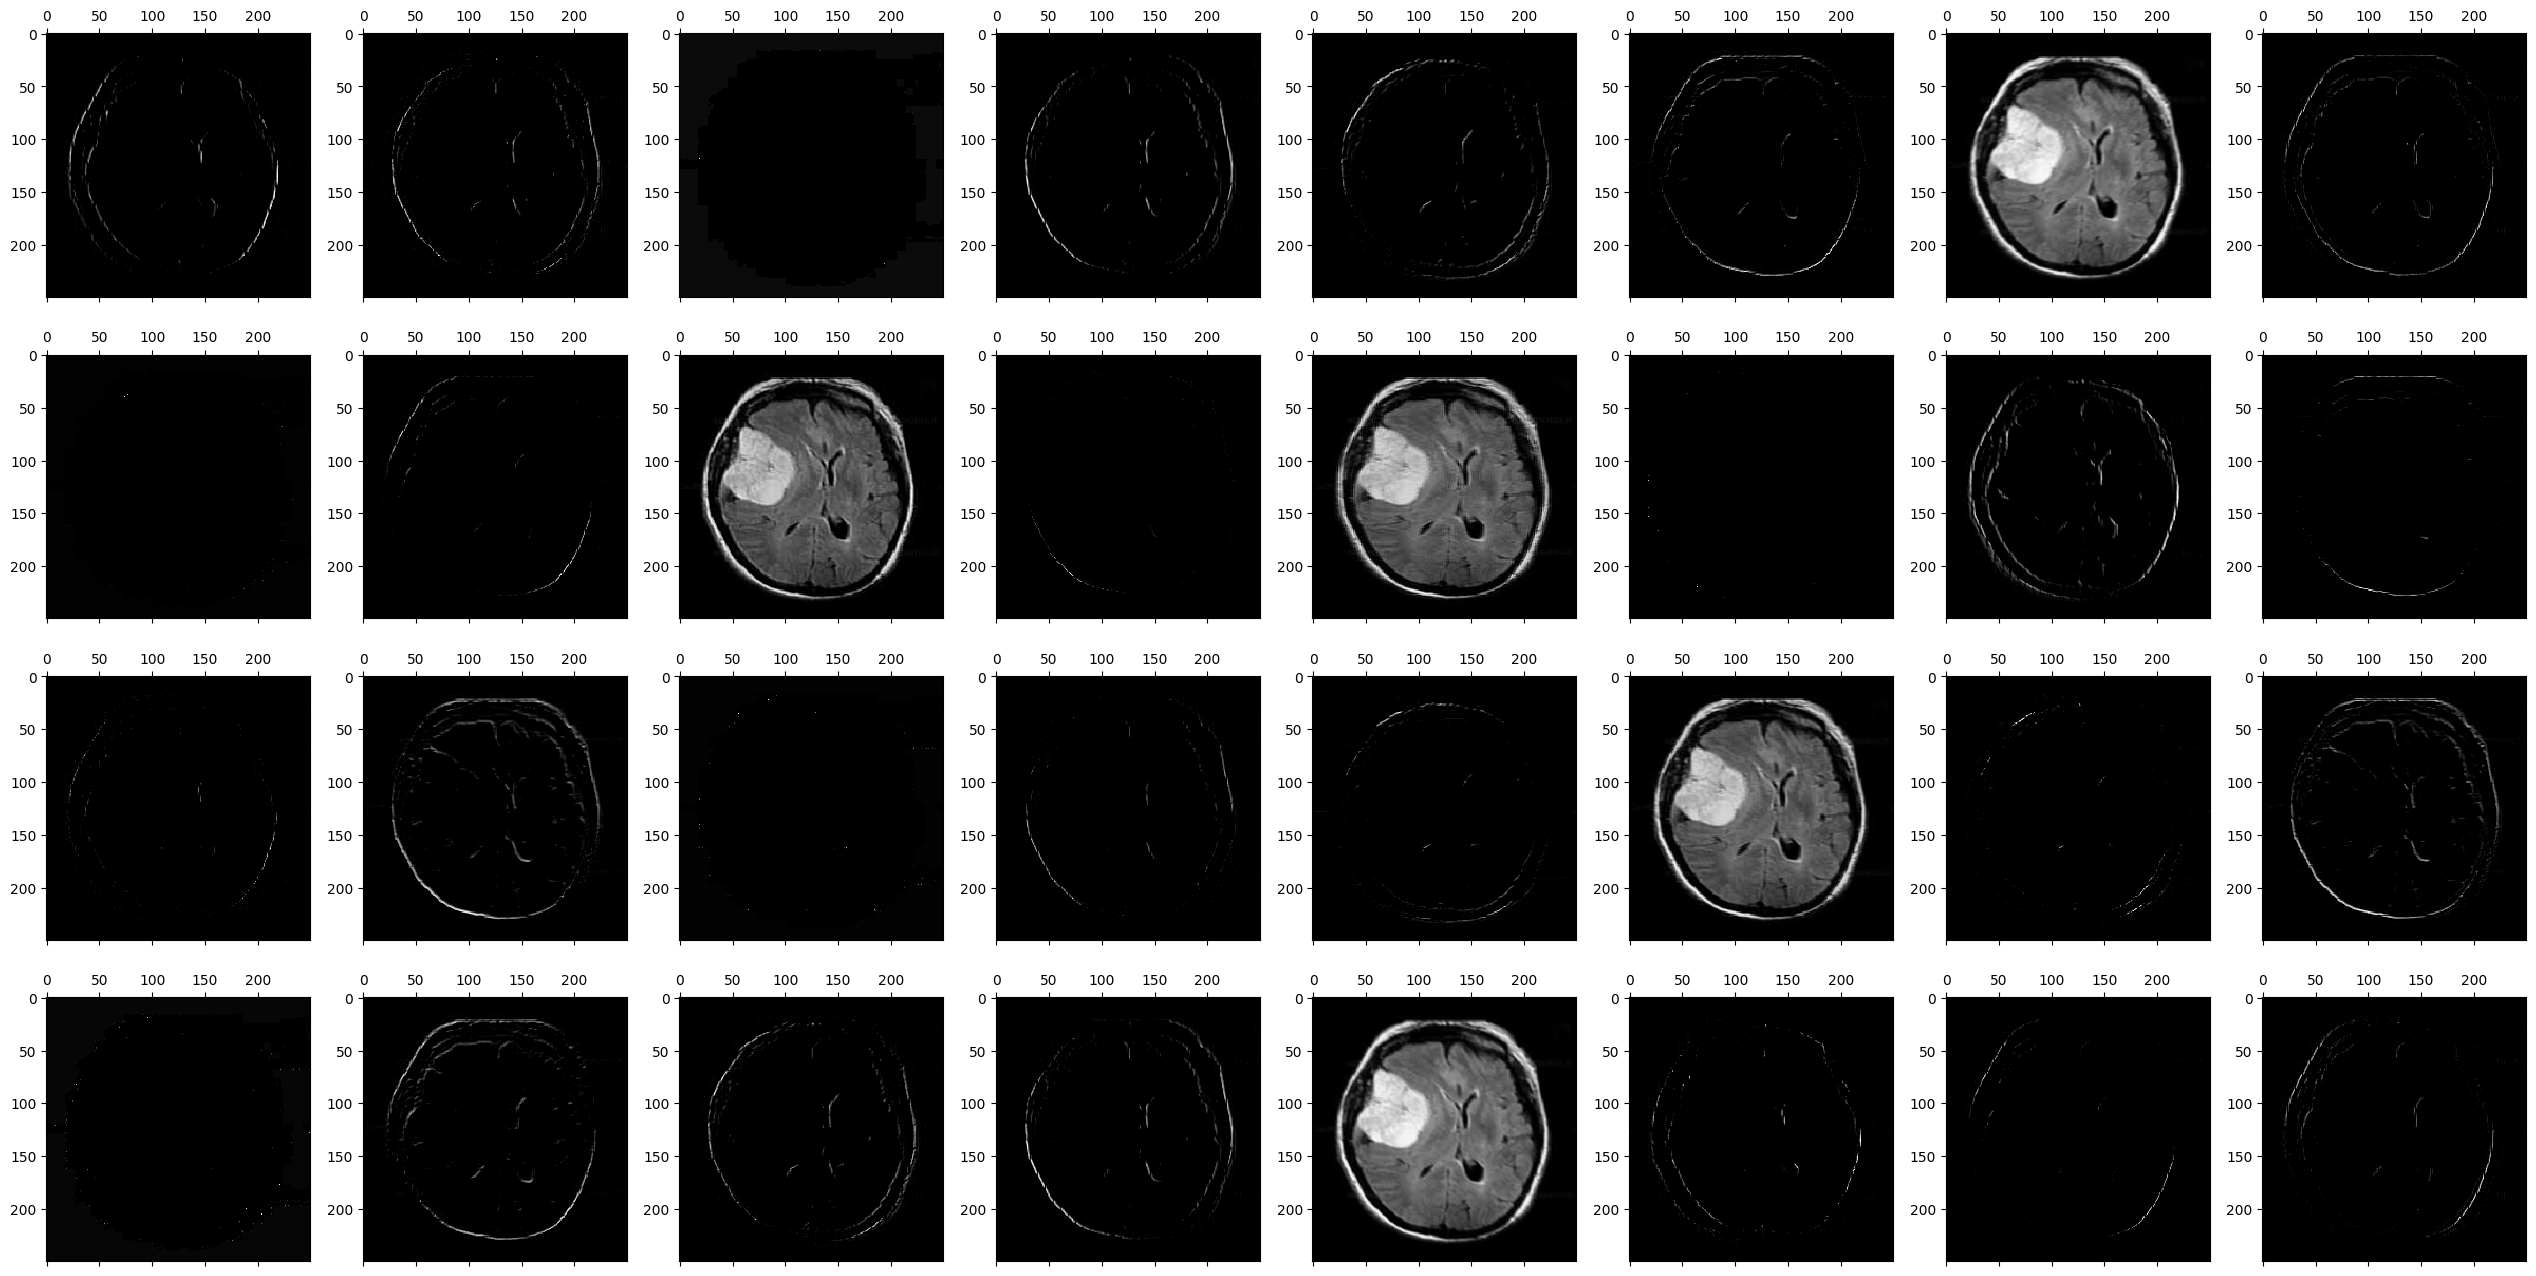

In [55]:
first_layer_activation = activations[0]

#visualize the activation of the first layer
fig, ax = plt.subplots(4, 8, figsize=(32, 16))
for k in range(8):
    ax[0, k].matshow(first_layer_activation[0, :, :, k], cmap='gray')
    ax[1, k].matshow(first_layer_activation[0, :, :, k+8], cmap='gray')
    ax[2, k].matshow(first_layer_activation[0, :, :, k+16], cmap='gray')
    ax[3, k].matshow(first_layer_activation[0, :, :, k+24], cmap='gray')
plt.show()

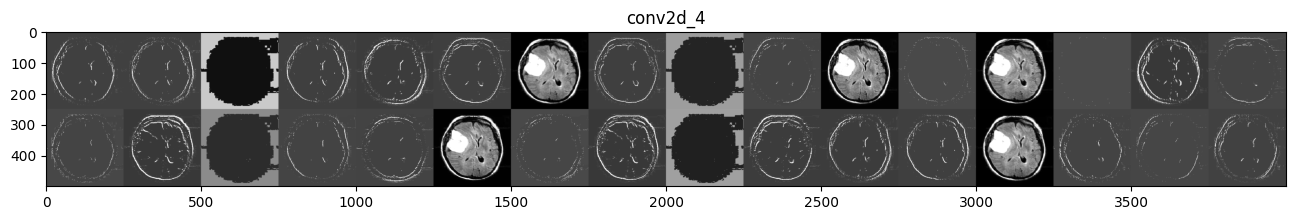

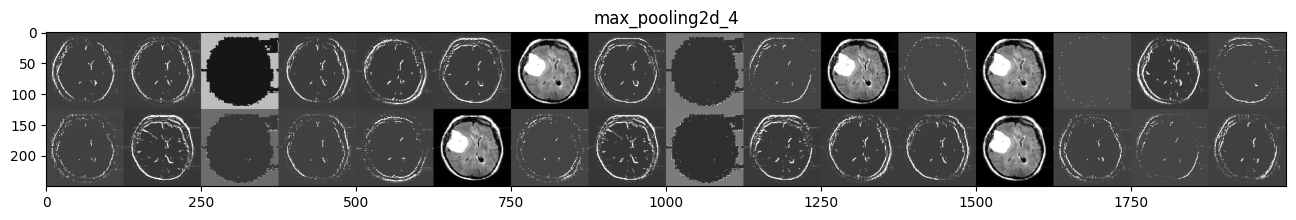

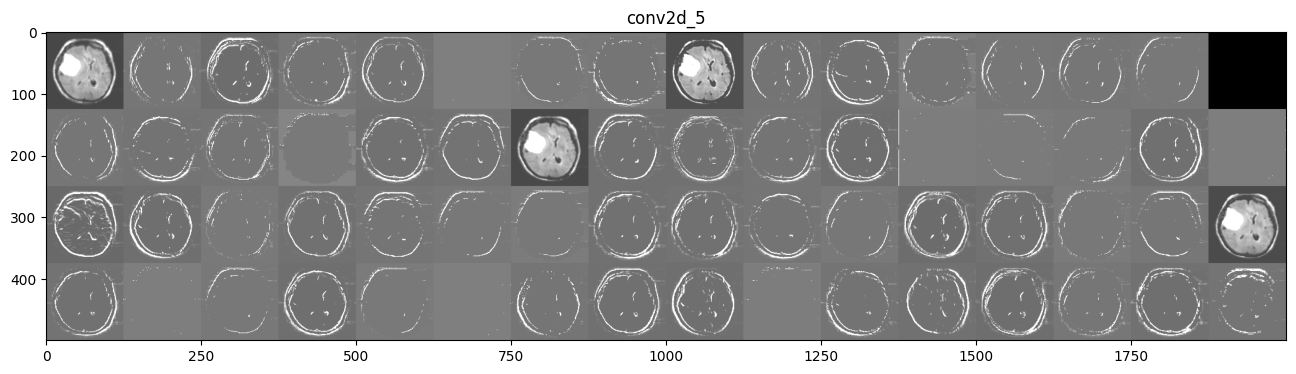

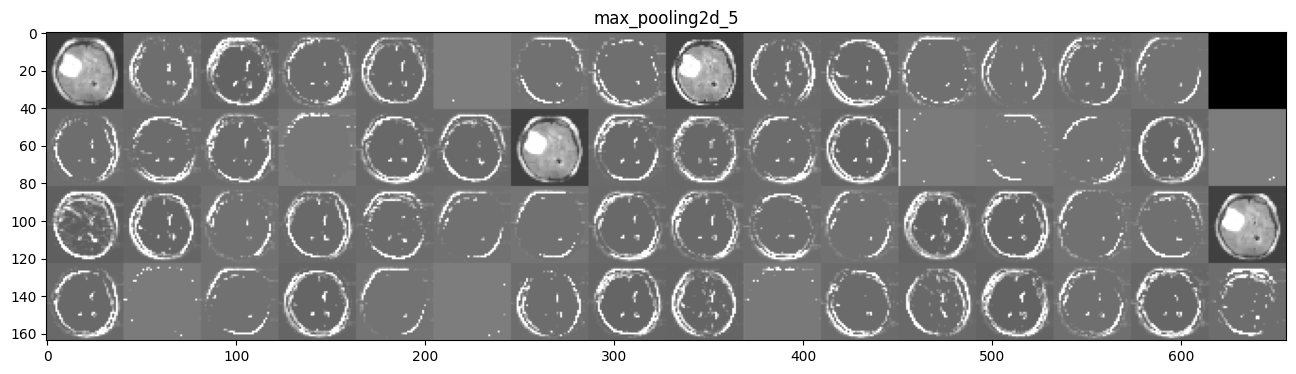

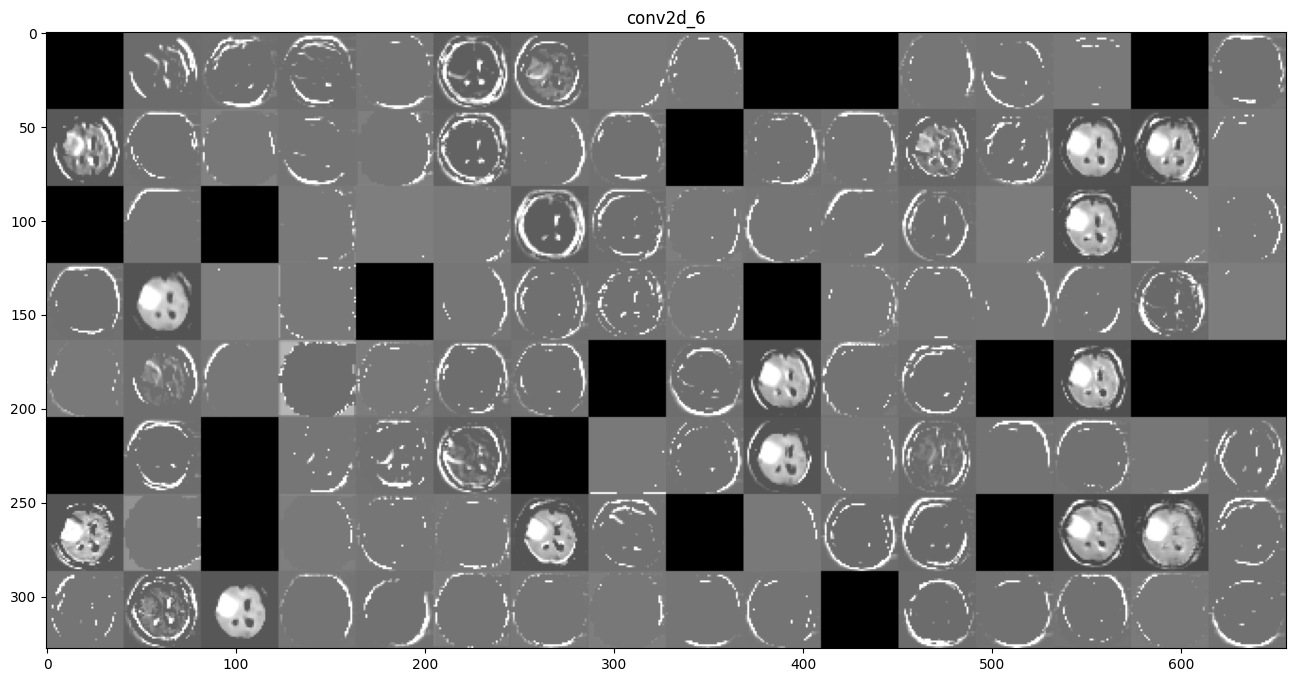

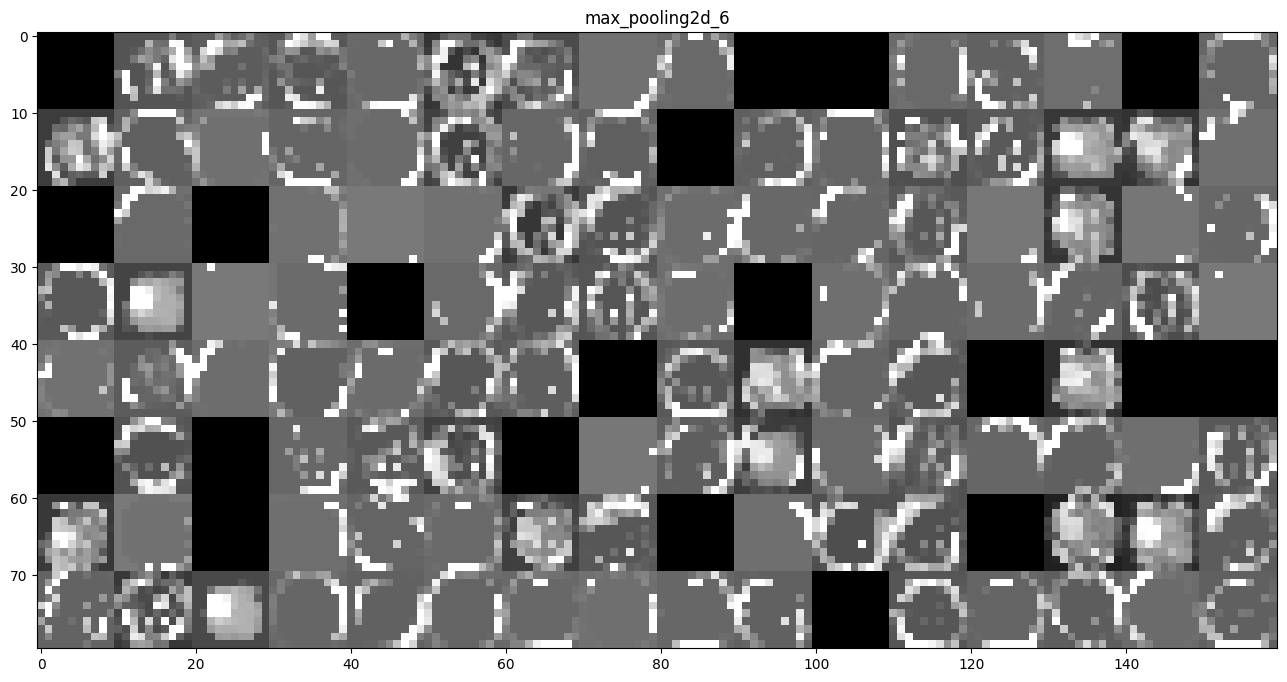

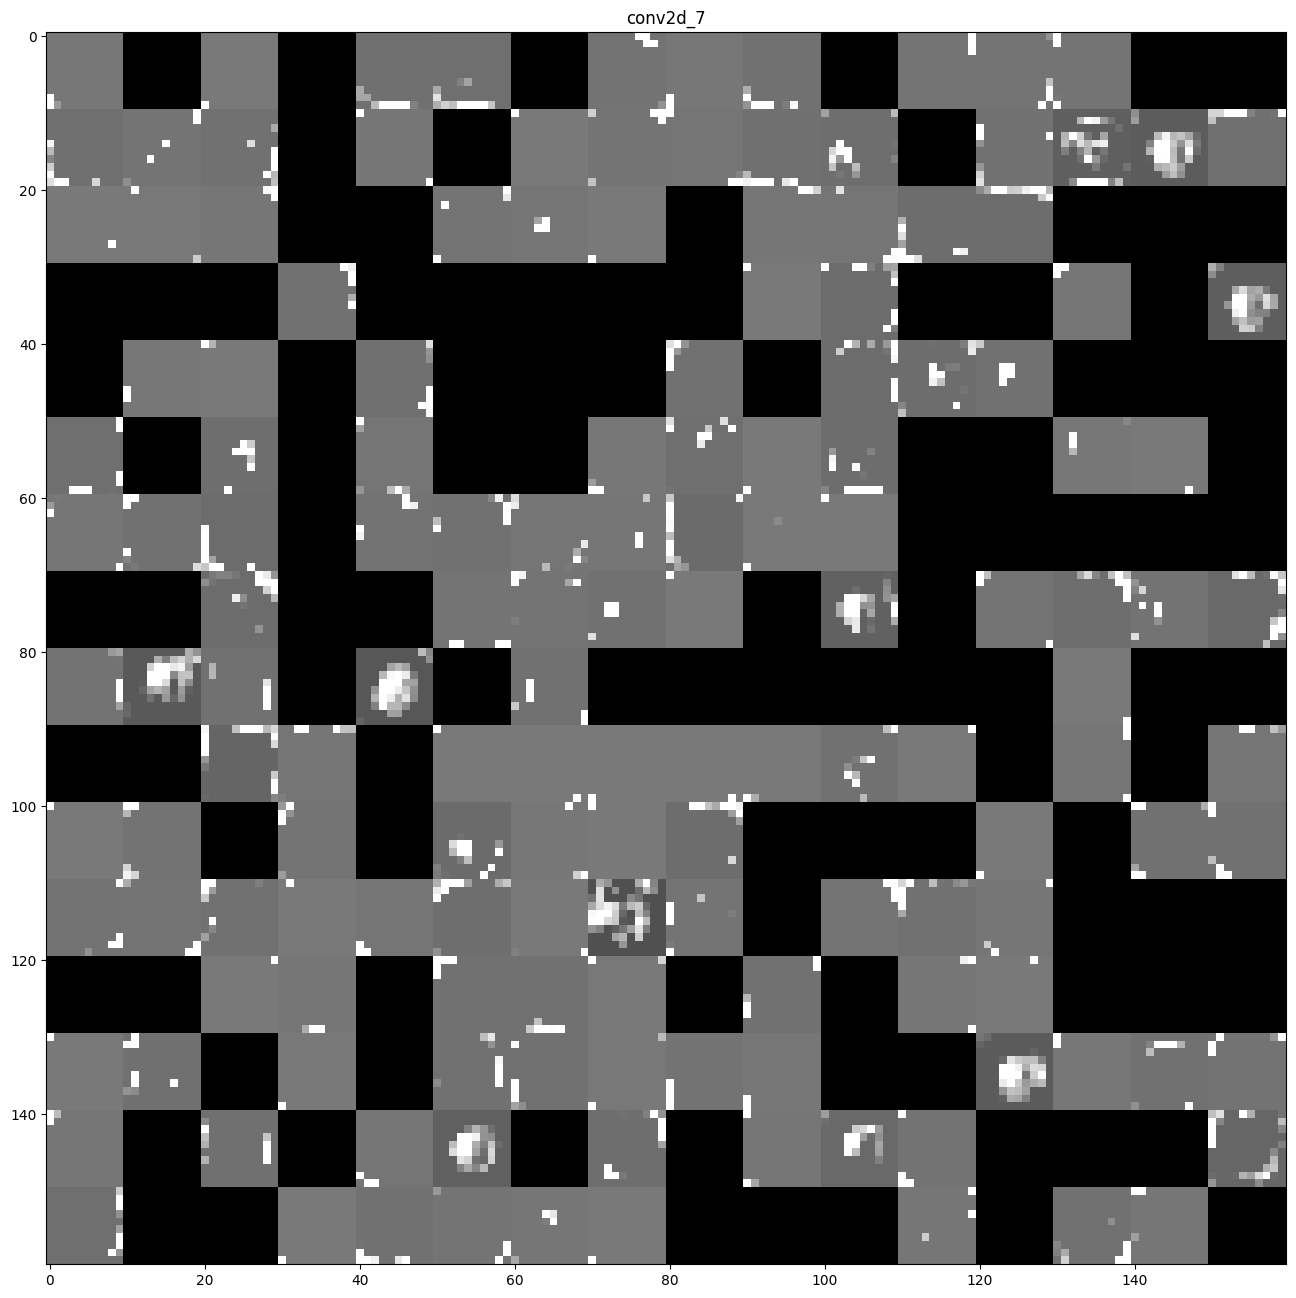

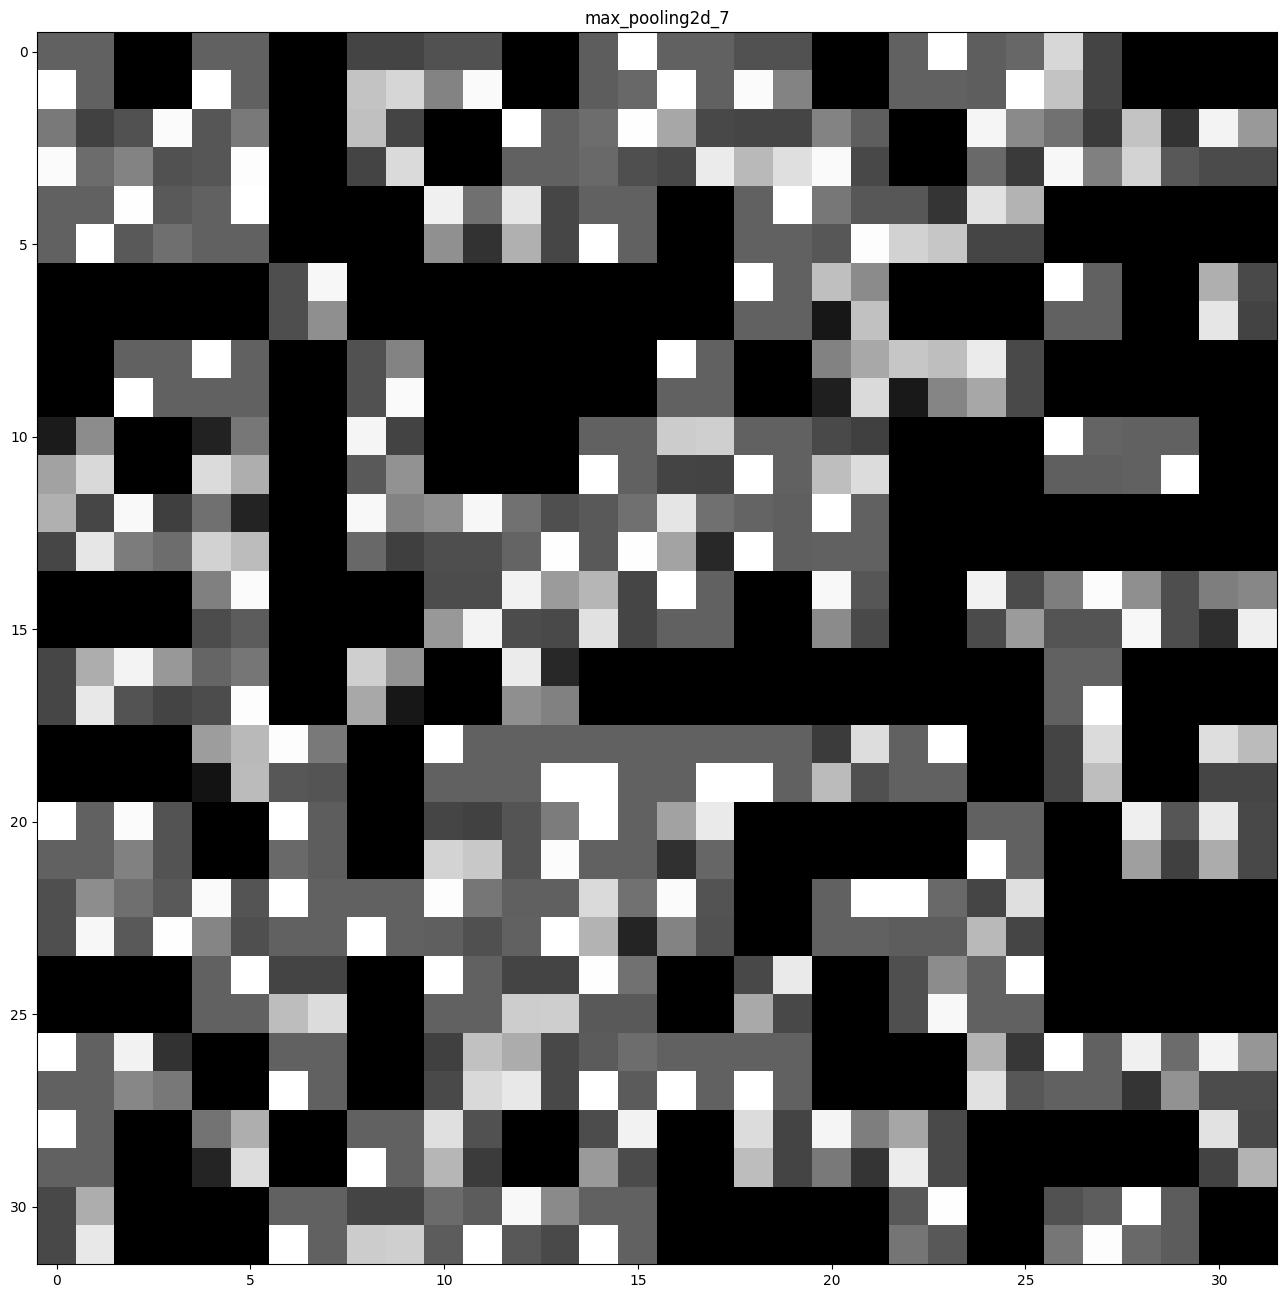

In [56]:
display_feature_map(layer_names,activations)

# Visualize Heatmap


In [14]:
img_tensor = get_img_for_pred(img_path, target_size=(image_size, image_size))
heatmap_scratch = make_heatmap(img_tensor, model, get_last_conv_layer_index(model), 1)
preds = model.predict(img_tensor)
decode_predictions(model,preds)

fig = plt.figure()
plt.imshow(heatmap_scratch)
plt.title("CNN from scratch")

NameError: ignored